In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# We express our sincere gratitude to the developers and contributors of the
# DGL library, particularly the example implementation of APPNP available at:
# https://github.com/dmlc/dgl/blob/master/examples/sparse/appnp.py
# This work served as a foundational reference and inspiration for our implementation.


In [ ]:
!pip uninstall -y dgl torch torchvision torchaudio
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install dgl==2.4.0+cu121 -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
!pip install --force-reinstall numpy==1.26.4
!pip install lime matplotlib scikit-learn

Found existing installation: dgl 2.4.0+cu121
Uninstalling dgl-2.4.0+cu121:
  Successfully uninstalled dgl-2.4.0+cu121
Found existing installation: torch 2.1.0+cu121
Uninstalling torch-2.1.0+cu121:
  Successfully uninstalled torch-2.1.0+cu121
Found existing installation: torchvision 0.16.0+cu121
Uninstalling torchvision-0.16.0+cu121:
  Successfully uninstalled torchvision-0.16.0+cu121
Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 58.2 MB/s  0:00:23
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.3 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torch]
Looking in links: https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.2/483.2 MB

In [ ]:
import dgl
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import torch.nn as nn
import torch.nn.functional as nnFn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/snu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load CN features
#cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
ad_fa_feature_path = "/home/snu/Downloads/Histogram_feature_AD_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
cn_features = np.array(list(cn_features_dict.values()))

# Load AD features
#ad_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_AD_dataset/Processed_histogram_features_AD/Histogram_feature_AD_FA_20bin.npy"
ad_features_dict = np.load(ad_fa_feature_path, allow_pickle=True).item()
ad_features = np.array(list(ad_features_dict.values()))
cn_labels = np.zeros(cn_features.shape[0])
ad_labels = np.ones(ad_features.shape[0])

In [ ]:
X = np.vstack((cn_features, ad_features))
y = np.hstack((cn_labels, ad_labels))

scaler = StandardScaler()
X = scaler.fit_transform(X)
num_nodes = X.shape[0]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1 # threshold
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src = src[mask]
dst = dst[mask]

graph = dgl.graph((src.cpu(), dst.cpu()), num_nodes=num_nodes, device='cpu')
graph = dgl.to_bidirected(graph)
graph = dgl.add_self_loop(graph)

graph = graph.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

Graph Nodes: 221, Edges: 8625, Device: cuda


In [ ]:
class APPNP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=512, dropout=0.2, num_hops=10, alpha=0.2):
        super().__init__()
        self.f_theta = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_size),
        )
        self.num_hops = num_hops
        self.A_dropout = nn.Dropout(dropout)
        self.alpha = alpha
        self.loss = self.cut_loss if cut else self.modularity_loss

    def forward(self, A_hat, X):
        Z_0 = Z = self.f_theta(X)
        for _ in range(self.num_hops):
            A_drop = dglsp.val_like(A_hat, self.A_dropout(A_hat.val))
            Z = (1 - self.alpha) * (A_drop @ Z) + self.alpha * Z_0
        return Z

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)
        return (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)
        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        return -(num / den)

In [ ]:
indices = torch.stack(graph.edges())
N = graph.num_nodes()
A = dglsp.spmatrix(indices, shape=(N, N))
I = dglsp.identity(A.shape, device=device)
A_hat = A + I
D_hat = dglsp.diag(A_hat.sum(dim=1)) ** -0.5
A_hat = D_hat @ A_hat @ D_hat

In [ ]:
num_epochs = 5000
lambda_unsup = 0.1
cut = 0

In [ ]:
A_dense = A_hat.to_dense()

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    ce_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(A_hat, X_tensor)

        sup_loss = ce_loss(out[train_mask], y_tensor[train_mask])
        unsup_loss = model.cut_loss(A_dense, out) if cut else model.modularity_loss(A_dense, out)
        total_loss = sup_loss + lambda_unsup * unsup_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Sup: {sup_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Total: {total_loss.item():.4f}")


    model.eval()
    with torch.no_grad():
        logits = model(A_hat, X_tensor)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    auc_val = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_val)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")



Training fold 1
Epoch 0 | Sup: 0.6870 | Unsup: -0.1251 | Total: 0.6745
Epoch 500 | Sup: 0.0137 | Unsup: -0.2223 | Total: -0.0085
Epoch 1000 | Sup: 0.0046 | Unsup: -0.2292 | Total: -0.0183
Epoch 1500 | Sup: 0.0017 | Unsup: -0.2340 | Total: -0.0217
Epoch 2000 | Sup: 0.0018 | Unsup: -0.2360 | Total: -0.0218
Epoch 2500 | Sup: 0.0012 | Unsup: -0.2371 | Total: -0.0225
Epoch 3000 | Sup: 0.0023 | Unsup: -0.2387 | Total: -0.0216
Epoch 3500 | Sup: 0.0014 | Unsup: -0.2405 | Total: -0.0226
Epoch 4000 | Sup: 0.0010 | Unsup: -0.2415 | Total: -0.0231
Epoch 4500 | Sup: 0.0008 | Unsup: -0.2441 | Total: -0.0236
Fold 1 | Acc: 0.7337 | Prec: 0.6512 | Rec: 0.7089 | F1: 0.6788 | Loss: 1.2367 | AUC: 0.7860

Training fold 2
Epoch 0 | Sup: 0.7093 | Unsup: -0.1257 | Total: 0.6967
Epoch 500 | Sup: 0.0275 | Unsup: -0.1960 | Total: 0.0079
Epoch 1000 | Sup: 0.0057 | Unsup: -0.2141 | Total: -0.0157
Epoch 1500 | Sup: 0.0028 | Unsup: -0.2197 | Total: -0.0192
Epoch 2000 | Sup: 0.0029 | Unsup: -0.2305 | Total: -0.0202


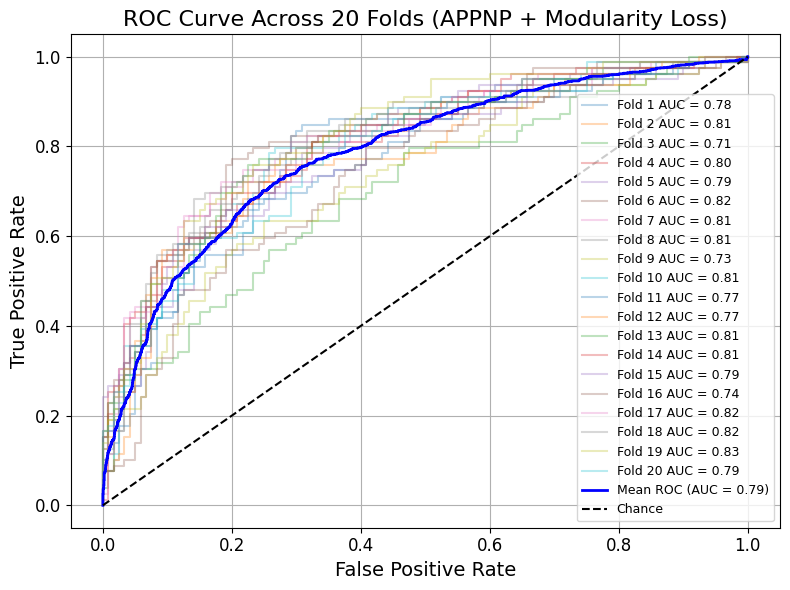

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (APPNP + Modularity Loss)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

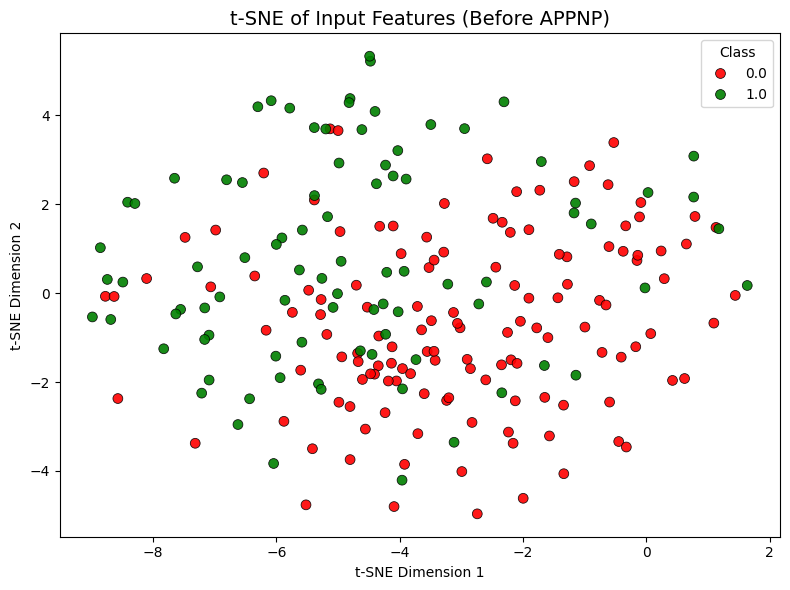

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_np = X_tensor.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_np)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y,
    palette=["red", "green"],
    s=50,
    alpha=0.9,
    edgecolor='black'
)
plt.title("t-SNE of Input Features (Before APPNP)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class", loc='best')
plt.tight_layout()
plt.show()


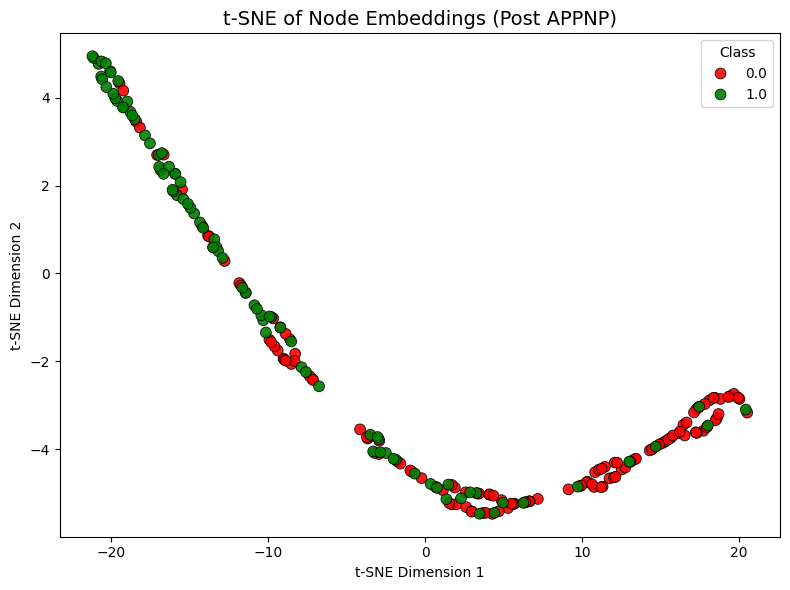

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


model.eval()
with torch.no_grad():
    logits = model(A_hat, X_tensor)
    embeddings = logits.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=y,
    palette=["red", "green"],
    s=60,
    alpha=0.9,
    edgecolor='black'
)

plt.title("t-SNE of Node Embeddings (Post APPNP)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class", loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc
import numpy as np

num_epochs = 5000
lambda_values = [0.01, 0.09, 0.5, 0.8, 1, 2, 5, 8]
cut = 0
A_dense = A_hat.to_dense()

all_ablation_results = {}

for lambda_unsup in lambda_values:
    print(f"\n========== Running for λ_unsup = {lambda_unsup} ==========\n")

    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

    accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
    all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

    for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
        print(f"\nTraining fold {fold + 1}")

        train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
        test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

        model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
        ce_loss = torch.nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(A_hat, X_tensor)

            sup_loss = ce_loss(out[train_mask], y_tensor[train_mask])
            unsup_loss = model.cut_loss(A_dense, out) if cut else model.modularity_loss(A_dense, out)
            total_loss = sup_loss + lambda_unsup * unsup_loss

            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
                break

            total_loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch {epoch} | Sup: {sup_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Total: {total_loss.item():.4f}")

        model.eval()
        with torch.no_grad():
            logits = model(A_hat, X_tensor)
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

        y_true_test = y_tensor[test_mask].cpu().numpy()
        y_pred_test = y_pred[test_mask.cpu().numpy()]
        y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

        acc = accuracy_score(y_true_test, y_pred_test)
        prec = precision_score(y_true_test, y_pred_test)
        rec = recall_score(y_true_test, y_pred_test)
        f1 = f1_score(y_true_test, y_pred_test)
        loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

        fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
        auc_val = auc(fpr, tpr)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        losses.append(loss_val)
        all_auc.append(auc_val)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_y_true.extend(y_true_test)
        all_y_proba.extend(y_proba_test)

        print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

    all_ablation_results[lambda_unsup] = {
        "Accuracy": (np.mean(accuracies), np.std(accuracies)),
        "Precision": (np.mean(precisions), np.std(precisions)),
        "Recall": (np.mean(recalls), np.std(recalls)),
        "F1 Score": (np.mean(f1_scores), np.std(f1_scores)),
        "Cross-Entropy Loss": (np.mean(losses), np.std(losses)),
        "AUC": (np.mean(all_auc), np.std(all_auc)),
    }

    print(f"\n==== λ_unsup = {lambda_unsup} | Average Results across 20 folds ====")
    print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
    print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")

print("\n========== Final Summary Across All λ_unsup Values ==========\n")
for lmbd, metrics in all_ablation_results.items():
    print(f"λ_unsup = {lmbd}")
    for metric_name, (mean_val, std_val) in metrics.items():
        print(f"{metric_name}: {mean_val:.4f} ± {std_val:.4f}")
    print("-" * 50)



========== Running for λ_unsup = 0.01 ==========


Training fold 1
Epoch 0 | Sup: 0.7053 | Unsup: -0.1251 | Total: 0.7040
Epoch 500 | Sup: 0.0154 | Unsup: -0.2182 | Total: 0.0132
Epoch 1000 | Sup: 0.0068 | Unsup: -0.2235 | Total: 0.0046
Epoch 1500 | Sup: 0.0053 | Unsup: -0.2272 | Total: 0.0030
Epoch 2000 | Sup: 0.0024 | Unsup: -0.2267 | Total: 0.0002
Epoch 2500 | Sup: 0.0025 | Unsup: -0.2275 | Total: 0.0002
Epoch 3000 | Sup: 0.0038 | Unsup: -0.2304 | Total: 0.0015
Epoch 3500 | Sup: 0.0012 | Unsup: -0.2293 | Total: -0.0011
Epoch 4000 | Sup: 0.0015 | Unsup: -0.2286 | Total: -0.0008
Epoch 4500 | Sup: 0.0009 | Unsup: -0.2309 | Total: -0.0014
Fold 1 | Acc: 0.7136 | Prec: 0.6250 | Rec: 0.6962 | F1: 0.6587 | Loss: 1.0412 | AUC: 0.7728

Training fold 2
Epoch 0 | Sup: 0.6872 | Unsup: -0.1254 | Total: 0.6859
Epoch 500 | Sup: 0.0270 | Unsup: -0.1905 | Total: 0.0251
Epoch 1000 | Sup: 0.0059 | Unsup: -0.1999 | Total: 0.0039
Epoch 1500 | Sup: 0.0039 | Unsup: -0.2056 | Total: 0.0018
Epoch 2000 | Sup

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.8195 | AUC: 0.5530

Training fold 3
Epoch 0 | Sup: 0.6911 | Unsup: -0.1279 | Total: -0.3318
Epoch 500 | Sup: 0.0458 | Unsup: -0.2233 | Total: -1.7404
Epoch 1000 | Sup: 0.0143 | Unsup: -0.2310 | Total: -1.8335
Epoch 1500 | Sup: 0.0072 | Unsup: -0.2345 | Total: -1.8684
Epoch 2000 | Sup: 0.0076 | Unsup: -0.2342 | Total: -1.8662
Epoch 2500 | Sup: 0.0026 | Unsup: -0.2346 | Total: -1.8740
Epoch 3000 | Sup: 0.0074 | Unsup: -0.2344 | Total: -1.8674
Epoch 3500 | Sup: 0.0055 | Unsup: -0.2351 | Total: -1.8750
Epoch 4000 | Sup: 0.0009 | Unsup: -0.2347 | Total: -1.8765
Epoch 4500 | Sup: 0.0015 | Unsup: -0.2348 | Total: -1.8771


/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.7917 | AUC: 0.5869

Training fold 4
Epoch 0 | Sup: 0.6875 | Unsup: -0.1263 | Total: -0.3227
Epoch 500 | Sup: 0.0274 | Unsup: -0.2444 | Total: -1.9277
Epoch 1000 | Sup: 0.0098 | Unsup: -0.2528 | Total: -2.0129
Epoch 1500 | Sup: 0.0026 | Unsup: -0.2539 | Total: -2.0286
Epoch 2000 | Sup: 0.0022 | Unsup: -0.2551 | Total: -2.0382
Epoch 2500 | Sup: 0.0009 | Unsup: -0.2550 | Total: -2.0395
Epoch 3000 | Sup: 0.0140 | Unsup: -0.2560 | Total: -2.0343
Epoch 3500 | Sup: 0.0008 | Unsup: -0.2558 | Total: -2.0457
Epoch 4000 | Sup: 0.0004 | Unsup: -0.2552 | Total: -2.0412
Epoch 4500 | Sup: 0.0009 | Unsup: -0.2556 | Total: -2.0441
Fold 4 | Acc: 0.7085 | Prec: 0.6296 | Rec: 0.6456 | F1: 0.6375 | Loss: 2.4901 | AUC: 0.7986

Training fold 5
Epoch 0 | Sup: 0.6939 | Unsup: -0.1261 | Total: -0.3150
Epoch 500 | Sup: 0.0436 | Unsup: -0.2375 | Total: -1.8564
Epoch 1000 | Sup: 0.0110 | Unsup: -0.2487 | Total: -1.9789
Epoch 1500 | Sup: 0.003

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 6 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.6179 | AUC: 0.5906

Training fold 7
Epoch 0 | Sup: 0.6891 | Unsup: -0.1255 | Total: -0.3150
Epoch 500 | Sup: 0.1266 | Unsup: -0.2246 | Total: -1.6705
Epoch 1000 | Sup: 0.0293 | Unsup: -0.2304 | Total: -1.8139
Epoch 1500 | Sup: 0.0371 | Unsup: -0.2332 | Total: -1.8288
Epoch 2000 | Sup: 0.0062 | Unsup: -0.2332 | Total: -1.8595
Epoch 2500 | Sup: 0.0066 | Unsup: -0.2335 | Total: -1.8615
Epoch 3000 | Sup: 0.0029 | Unsup: -0.2337 | Total: -1.8670
Epoch 3500 | Sup: 0.0056 | Unsup: -0.2340 | Total: -1.8661
Epoch 4000 | Sup: 0.0016 | Unsup: -0.2332 | Total: -1.8643
Epoch 4500 | Sup: 0.0069 | Unsup: -0.2338 | Total: -1.8636


/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 7 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.5702 | AUC: 0.6074

Training fold 8
Epoch 0 | Sup: 0.7373 | Unsup: -0.1258 | Total: -0.2687
Epoch 500 | Sup: 0.0695 | Unsup: -0.2270 | Total: -1.7465
Epoch 1000 | Sup: 0.0268 | Unsup: -0.2435 | Total: -1.9215
Epoch 1500 | Sup: 0.0112 | Unsup: -0.2473 | Total: -1.9671
Epoch 2000 | Sup: 0.0063 | Unsup: -0.2476 | Total: -1.9743
Epoch 2500 | Sup: 0.0032 | Unsup: -0.2482 | Total: -1.9823
Epoch 3000 | Sup: 0.0019 | Unsup: -0.2482 | Total: -1.9840
Epoch 3500 | Sup: 0.0023 | Unsup: -0.2483 | Total: -1.9844
Epoch 4000 | Sup: 0.0085 | Unsup: -0.2489 | Total: -1.9830
Epoch 4500 | Sup: 0.0010 | Unsup: -0.2486 | Total: -1.9877
Fold 8 | Acc: 0.7588 | Prec: 0.7123 | Rec: 0.6582 | F1: 0.6842 | Loss: 1.9890 | AUC: 0.8026

Training fold 9
Epoch 0 | Sup: 0.7091 | Unsup: -0.1251 | Total: -0.2917
Epoch 500 | Sup: 0.0608 | Unsup: -0.2422 | Total: -1.8768
Epoch 1000 | Sup: 0.0079 | Unsup: -0.2480 | Total: -1.9758
Epoch 1500 | Sup: 0.005

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 12 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.6456 | AUC: 0.4521

Training fold 13
Epoch 0 | Sup: 0.6935 | Unsup: -0.1259 | Total: -0.3133
Epoch 500 | Sup: 0.0231 | Unsup: -0.2483 | Total: -1.9631
Epoch 1000 | Sup: 0.0020 | Unsup: -0.2547 | Total: -2.0356
Epoch 1500 | Sup: 0.0092 | Unsup: -0.2559 | Total: -2.0379
Epoch 2000 | Sup: 0.0050 | Unsup: -0.2567 | Total: -2.0487
Epoch 2500 | Sup: 0.0012 | Unsup: -0.2569 | Total: -2.0543
Epoch 3000 | Sup: 0.0006 | Unsup: -0.2566 | Total: -2.0522
Epoch 3500 | Sup: 0.0012 | Unsup: -0.2571 | Total: -2.0552
Epoch 4000 | Sup: 0.0003 | Unsup: -0.2572 | Total: -2.0570
Epoch 4500 | Sup: 0.0008 | Unsup: -0.2571 | Total: -2.0559
Fold 13 | Acc: 0.7337 | Prec: 0.7097 | Rec: 0.5570 | F1: 0.6241 | Loss: 2.2376 | AUC: 0.7979

Training fold 14
Epoch 0 | Sup: 0.6774 | Unsup: -0.1282 | Total: -0.3479
Epoch 500 | Sup: 0.0942 | Unsup: -0.2247 | Total: -1.7033
Epoch 1000 | Sup: 0.0206 | Unsup: -0.2310 | Total: -1.8273
Epoch 1500 | Sup: 0

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 14 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.7230 | AUC: 0.5577

Training fold 15
Epoch 0 | Sup: 0.7507 | Unsup: -0.1279 | Total: -0.2722
Epoch 500 | Sup: 0.0888 | Unsup: -0.2257 | Total: -1.7165
Epoch 1000 | Sup: 0.0750 | Unsup: -0.2337 | Total: -1.7944
Epoch 1500 | Sup: 0.0190 | Unsup: -0.2336 | Total: -1.8500
Epoch 2000 | Sup: 0.0028 | Unsup: -0.2331 | Total: -1.8619
Epoch 2500 | Sup: 0.0023 | Unsup: -0.2336 | Total: -1.8664
Epoch 3000 | Sup: 0.0022 | Unsup: -0.2334 | Total: -1.8647
Epoch 3500 | Sup: 0.0026 | Unsup: -0.2336 | Total: -1.8662
Epoch 4000 | Sup: 0.0088 | Unsup: -0.2339 | Total: -1.8626
Epoch 4500 | Sup: 0.0045 | Unsup: -0.2336 | Total: -1.8646


/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 15 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.7415 | AUC: 0.5288

Training fold 16
Epoch 0 | Sup: 0.6959 | Unsup: -0.1251 | Total: -0.3048
Epoch 500 | Sup: 0.0672 | Unsup: -0.2205 | Total: -1.6969
Epoch 1000 | Sup: 0.0187 | Unsup: -0.2291 | Total: -1.8140
Epoch 1500 | Sup: 0.0082 | Unsup: -0.2314 | Total: -1.8429
Epoch 2000 | Sup: 0.0043 | Unsup: -0.2316 | Total: -1.8485
Epoch 2500 | Sup: 0.0039 | Unsup: -0.2317 | Total: -1.8495
Epoch 3000 | Sup: 0.0007 | Unsup: -0.2321 | Total: -1.8557
Epoch 3500 | Sup: 0.0030 | Unsup: -0.2327 | Total: -1.8583
Epoch 4000 | Sup: 0.0014 | Unsup: -0.2317 | Total: -1.8525
Epoch 4500 | Sup: 0.0204 | Unsup: -0.2330 | Total: -1.8433
Fold 16 | Acc: 0.6884 | Prec: 0.8696 | Rec: 0.2532 | F1: 0.3922 | Loss: 2.7092 | AUC: 0.7092

Training fold 17
Epoch 0 | Sup: 0.7325 | Unsup: -0.1272 | Total: -0.2850
Epoch 500 | Sup: 0.0776 | Unsup: -0.2266 | Total: -1.7351
Epoch 1000 | Sup: 0.0691 | Unsup: -0.2346 | Total: -1.8079
Epoch 1500 | Sup: 0

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 17 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.7036 | AUC: 0.6224

Training fold 18
Epoch 0 | Sup: 0.6981 | Unsup: -0.1353 | Total: -0.3843
Epoch 500 | Sup: 0.1236 | Unsup: -0.2242 | Total: -1.6697
Epoch 1000 | Sup: 0.0280 | Unsup: -0.2307 | Total: -1.8175
Epoch 1500 | Sup: 0.0082 | Unsup: -0.2322 | Total: -1.8496
Epoch 2000 | Sup: 0.0041 | Unsup: -0.2328 | Total: -1.8584
Epoch 2500 | Sup: 0.0063 | Unsup: -0.2334 | Total: -1.8611
Epoch 3000 | Sup: 0.0040 | Unsup: -0.2334 | Total: -1.8633
Epoch 3500 | Sup: 0.0050 | Unsup: -0.2335 | Total: -1.8632
Epoch 4000 | Sup: 0.0049 | Unsup: -0.2336 | Total: -1.8643
Epoch 4500 | Sup: 0.0062 | Unsup: -0.2337 | Total: -1.8635


/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 18 | Acc: 0.6030 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000 | Loss: 3.4125 | AUC: 0.6495

Training fold 19
Epoch 0 | Sup: 0.7102 | Unsup: -0.1253 | Total: -0.2920
Epoch 500 | Sup: 0.0494 | Unsup: -0.2446 | Total: -1.9071
Epoch 1000 | Sup: 0.0072 | Unsup: -0.2512 | Total: -2.0024
Epoch 1500 | Sup: 0.0018 | Unsup: -0.2521 | Total: -2.0150
Epoch 2000 | Sup: 0.0021 | Unsup: -0.2532 | Total: -2.0235
Epoch 2500 | Sup: 0.0012 | Unsup: -0.2536 | Total: -2.0274
Epoch 3000 | Sup: 0.0153 | Unsup: -0.2538 | Total: -2.0151
Epoch 3500 | Sup: 0.0011 | Unsup: -0.2537 | Total: -2.0285
Epoch 4000 | Sup: 0.0014 | Unsup: -0.2538 | Total: -2.0286
Epoch 4500 | Sup: 0.0007 | Unsup: -0.2539 | Total: -2.0302
Fold 19 | Acc: 0.7437 | Prec: 0.7188 | Rec: 0.5823 | F1: 0.6434 | Loss: 2.1092 | AUC: 0.8111

Training fold 20
Epoch 0 | Sup: 0.7083 | Unsup: -0.1252 | Total: -0.2937
Epoch 500 | Sup: 0.0227 | Unsup: -0.2466 | Total: -1.9504
Epoch 1000 | Sup: 0.0049 | Unsup: -0.2537 | Total: -2.0251
Epoch 1500 | Sup: 0